# More Examples on Linear Regression

First, we will consider the statsmodels module.

In [1]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import statsmodels.formula.api as smf
import pandas

import seaborn as sns
%matplotlib inline

np.random.seed(9876789)




In [2]:
nsample = 100
x = np.linspace(0, 10, 100)
#print(x)
X = np.column_stack((x, x**2))
print(X)
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

[[  0.00000000e+00   0.00000000e+00]
 [  1.01010101e-01   1.02030405e-02]
 [  2.02020202e-01   4.08121620e-02]
 [  3.03030303e-01   9.18273646e-02]
 [  4.04040404e-01   1.63248648e-01]
 [  5.05050505e-01   2.55076013e-01]
 [  6.06060606e-01   3.67309458e-01]
 [  7.07070707e-01   4.99948985e-01]
 [  8.08080808e-01   6.52994592e-01]
 [  9.09090909e-01   8.26446281e-01]
 [  1.01010101e+00   1.02030405e+00]
 [  1.11111111e+00   1.23456790e+00]
 [  1.21212121e+00   1.46923783e+00]
 [  1.31313131e+00   1.72431385e+00]
 [  1.41414141e+00   1.99979594e+00]
 [  1.51515152e+00   2.29568411e+00]
 [  1.61616162e+00   2.61197837e+00]
 [  1.71717172e+00   2.94867871e+00]
 [  1.81818182e+00   3.30578512e+00]
 [  1.91919192e+00   3.68329762e+00]
 [  2.02020202e+00   4.08121620e+00]
 [  2.12121212e+00   4.49954086e+00]
 [  2.22222222e+00   4.93827160e+00]
 [  2.32323232e+00   5.39740843e+00]
 [  2.42424242e+00   5.87695133e+00]
 [  2.52525253e+00   6.37690032e+00]
 [  2.62626263e+00   6.89725538e+00]
 

We add one more column of ones (1) so that we can estimate the intercept!! Otherwise, it will not produce the intercept, only the slope by default!! (Assumes data normalized!)

In [3]:
X = sm.add_constant(X)
y = np.dot(X, beta) + e

#print(y)


Now we have the explanatory variable X (predictor, regressor, input variable) and the response variable y (predicted, regressand, output). Ready to fit the model!!

In [4]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.020e+06
Date:                Wed, 09 Nov 2016   Prob (F-statistic):          2.83e-239
Time:                        13:28:35   Log-Likelihood:                -146.51
No. Observations:                 100   AIC:                             299.0
Df Residuals:                      97   BIC:                             306.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.3423      0.313      4.292      0.0

In [5]:
#dir(results)
print('Parameters: ', results.params)
print('R2: ', results.rsquared)
print('Predicted values: ', results.predict())

Parameters:  [  1.34233516  -0.04024948  10.01025357]
R2:  0.999987936503
Predicted values:  [    1.34233516     1.44040458     1.74274404     2.24935355     2.9602331
     3.87538271     4.99480235     6.31849204     7.84645178     9.57868156
    11.51518139    13.65595126    16.00099118    18.55030114    21.30388115
    24.2617312     27.4238513     30.79024145    34.36090164    38.13583187
    42.11503215    46.29850248    50.68624285    55.27825327    60.07453373
    65.07508424    70.27990479    75.68899539    81.30235603    87.11998672
    93.14188746    99.36805824   105.79849906   112.43320993   119.27219085
   126.31544181   133.56296282   141.01475387   148.67081497   156.53114611
   164.5957473    172.86461853   181.33775981   190.01517113   198.8968525
   207.98280392   217.27302538   226.76751688   236.46627843   246.36931003
   256.47661167   266.78818336   277.30402509   288.02413687   298.94851869
   310.07717056   321.41009247   332.94728443   344.68874643   356.634478

In [6]:
from statsmodels.datasets.longley import load_pandas
y = load_pandas().endog
X = load_pandas().exog
X = sm.add_constant(X)

In [7]:
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Wed, 09 Nov 2016   Prob (F-statistic):           4.98e-10
Time:                        13:28:35   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3.482e+06    8.9e+05     -3.911      0.0

/Users/crovella/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


Also, dropping a single observation can have a dramatic effect on the coefficient estimates:

In [8]:
ols_results2 = sm.OLS(y.ix[:14], X.ix[:14]).fit()
print("Percentage change %4.2f%%\n"*7 % tuple([i for i in (ols_results2.params - ols_results.params)/ols_results.params*100]))

Percentage change -13.35%
Percentage change -236.18%
Percentage change -23.69%
Percentage change -3.36%
Percentage change -7.26%
Percentage change -200.46%
Percentage change -13.34%



We can also look at formal statistics for this such as the DFBETAS -- a standardized measure of how much each coefficient changes when that observation is left out.

In [9]:
infl = ols_results.get_influence()
## significant influence
2./len(X)**.5

0.5

In [10]:
print(infl.summary_frame().filter(regex="dfb"))

    dfb_const  dfb_GNPDEFL   dfb_GNP  dfb_UNEMP  dfb_ARMED   dfb_POP  dfb_YEAR
0   -0.016406    -0.234566 -0.045095  -0.121513  -0.149026  0.211057  0.013388
1   -0.020608    -0.289091  0.124453   0.156964   0.287700 -0.161890  0.025958
2   -0.008382     0.007161 -0.016799   0.009575   0.002227  0.014871  0.008103
3    0.018093     0.907968 -0.500022  -0.495996   0.089996  0.711142 -0.040056
4    1.871260    -0.219351  1.611418   1.561520   1.169337 -1.081513 -1.864186
5   -0.321373    -0.077045 -0.198129  -0.192961  -0.430626  0.079916  0.323275
6    0.315945    -0.241983  0.438146   0.471797  -0.019546 -0.448515 -0.307517
7    0.015816    -0.002742  0.018591   0.005064  -0.031320 -0.015823 -0.015583
8   -0.004019    -0.045687  0.023708   0.018125   0.013683 -0.034770  0.005116
9   -1.018242    -0.282131 -0.412621  -0.663904  -0.715020 -0.229501  1.035723
10   0.030947    -0.024781  0.029480   0.035361   0.034508 -0.014194 -0.030805
11   0.005987    -0.079727  0.030276  -0.008883  -0.

We can use another version of the module that can directly type formulas and expressions in the functions of the models.
We can specify the name of the columns to be used to predict another column, remove columns, etc..

In [11]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data
df = df[['Lottery', 'Literacy', 'Wealth', 'Region']].dropna()
df.head()

,Lottery,Literacy,Wealth,Region
0,41,37,73,E
1,38,51,22,N
2,66,13,61,C
3,80,46,76,E
4,79,69,83,E


In [12]:
mod = smf.ols(formula='Lottery ~ Literacy + Wealth + Region', data=df)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Wed, 09 Nov 2016   Prob (F-statistic):           1.07e-05
Time:                        13:28:36   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

Categorical variables

Looking at the summary printed above, notice that patsy determined that elements of Region were text strings, so it treated Region as a categorical variable. patsy‘s default is also to include an intercept, so we automatically dropped one of the Region categories.

If Region had been an integer variable that we wanted to treat explicitly as categorical, we could have done so by using the C() operator.

Removing variables

The “-” sign can be used to remove columns/variables. For instance, we can remove the intercept from a model by:



In [13]:
res = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region) -1 ', data=df).fit()
print(res.params)

C(Region)[C]    38.651655
C(Region)[E]    23.223870
C(Region)[N]    28.634694
C(Region)[S]    34.103399
C(Region)[W]    28.560379
Literacy        -0.185819
Wealth           0.451475
dtype: float64


Functions

You can also apply vectorized functions to the variables in your model:



In [14]:
res = smf.ols(formula='Lottery ~ np.log(Literacy)', data=df).fit()
print(res.params)

Intercept           115.609119
np.log(Literacy)    -20.393959
dtype: float64


Regression Plots

In [15]:
from __future__ import print_function
from statsmodels.compat import lzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
%matplotlib inline

In [16]:
from statsmodels.formula.api import ols

prestige = sm.datasets.get_rdataset("Duncan", "car", cache=True).data


In [17]:
prestige.head()

,type,income,education,prestige
accountant,prof,62,86,82
pilot,prof,72,76,83
architect,prof,75,92,90
author,prof,55,90,76
chemist,prof,64,86,90


In [18]:
prestige_model = ols("prestige ~ income + education", data=prestige).fit()
print(prestige_model.summary())


                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     101.2
Date:                Wed, 09 Nov 2016   Prob (F-statistic):           8.65e-17
Time:                        13:28:37   Log-Likelihood:                -178.98
No. Observations:                  45   AIC:                             364.0
Df Residuals:                      42   BIC:                             369.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.1

Influence plots


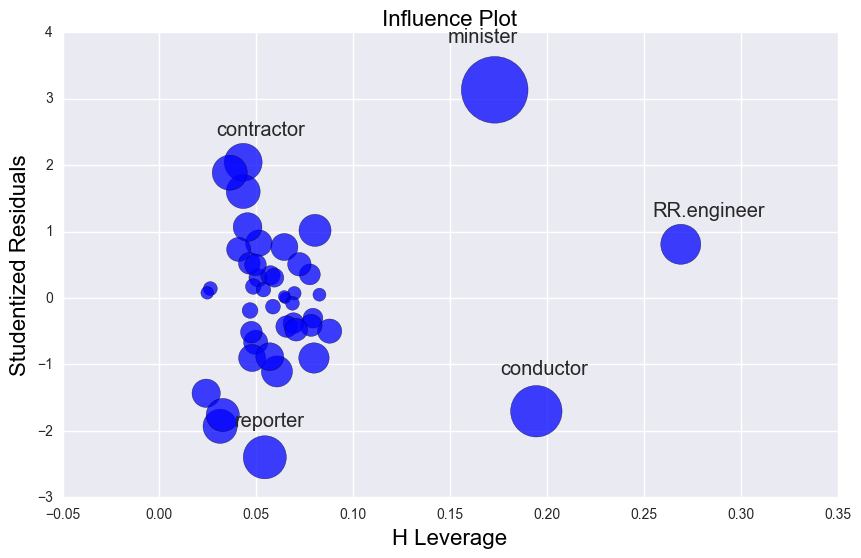

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(prestige_model, ax=ax, criterion="cooks")

As you can see there are a few worrisome observations. Both contractor and reporter have low leverage but a large residual. 
RR.engineer has small residual and large leverage. Conductor and minister have both high leverage and large residuals, and, 
therefore, large influence.

Partial Regression Plots

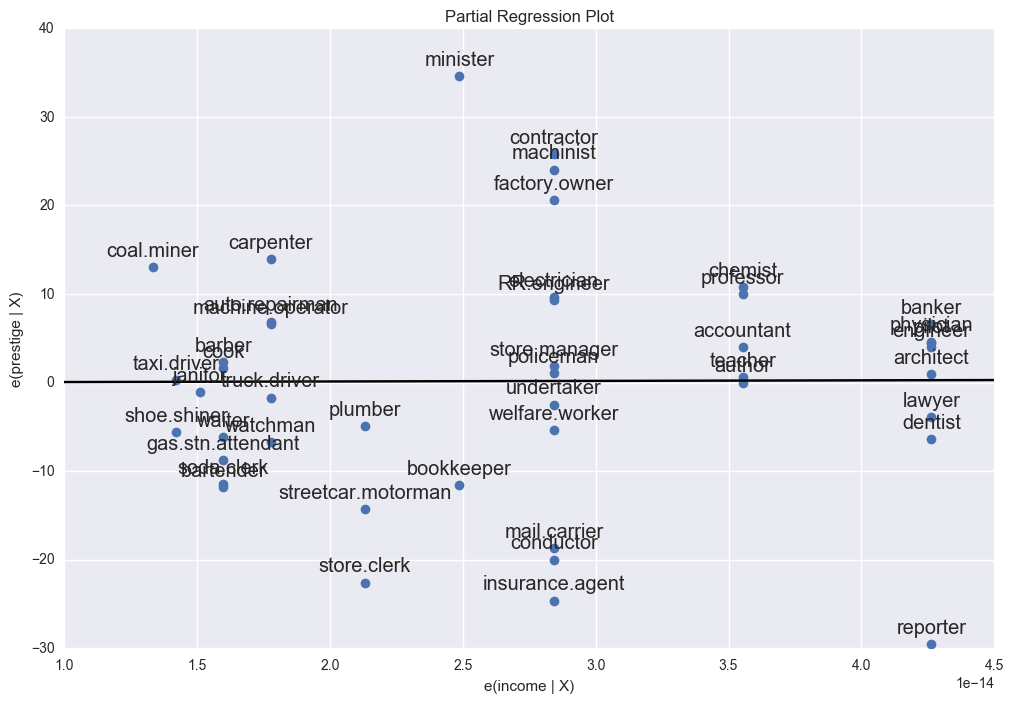

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress("prestige", "income", ["income", "education"], data=prestige, ax=ax)


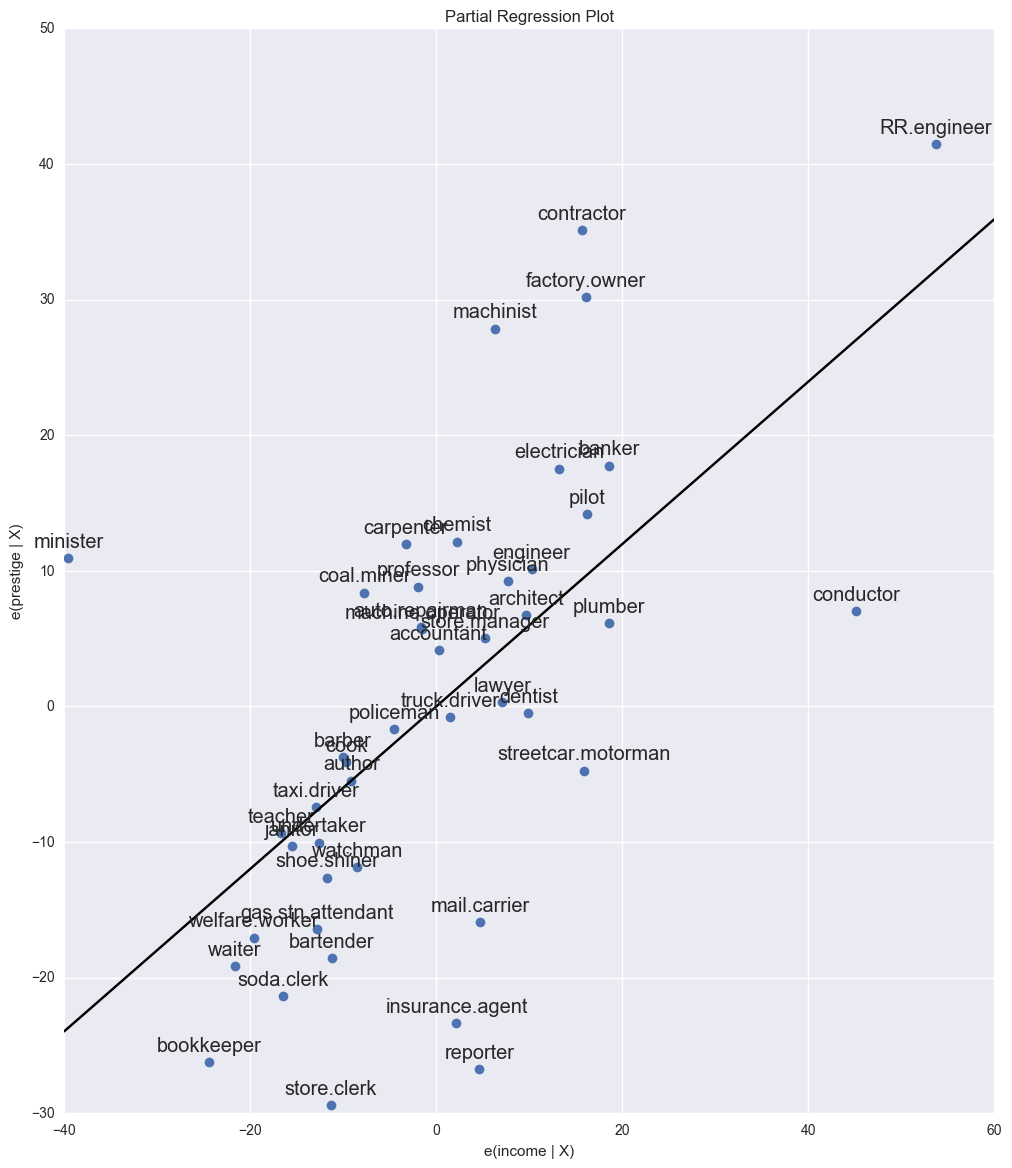

In [21]:

fix, ax = plt.subplots(figsize=(12,14))
fig = sm.graphics.plot_partregress("prestige", "income", ["education"], data=prestige, ax=ax)

As you can see the partial regression plot confirms the influence of conductor, minister, and RR.engineer on the partial relationship between income and prestige. The cases greatly decrease the effect of income on prestige. Dropping these cases confirms this.

In [22]:
subset = ~prestige.index.isin(["conductor", "RR.engineer", "minister"])
prestige_model2 = ols("prestige ~ income + education", data=prestige, subset=subset).fit()
print(prestige_model2.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     138.1
Date:                Wed, 09 Nov 2016   Prob (F-statistic):           2.02e-18
Time:                        13:28:38   Log-Likelihood:                -160.59
No. Observations:                  42   AIC:                             327.2
Df Residuals:                      39   BIC:                             332.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.3174      3.680     -1.717      0.0

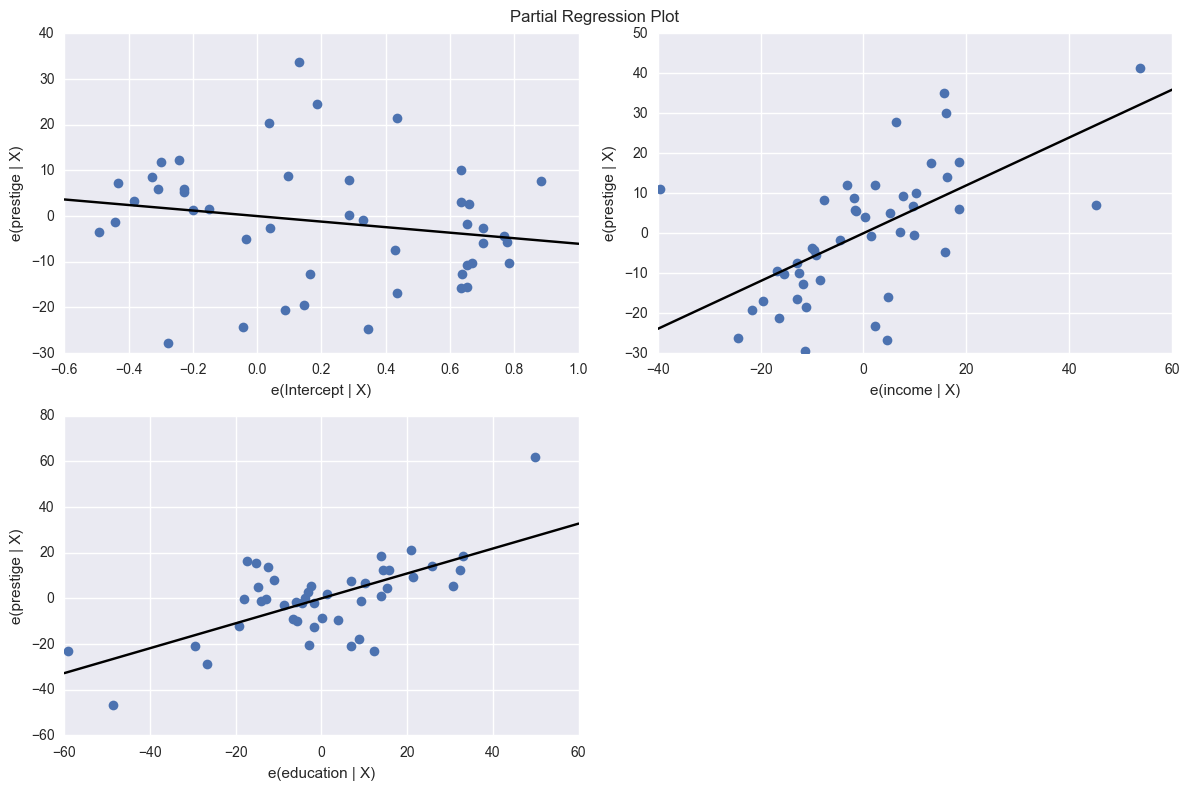

In [23]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(prestige_model, fig=fig)

More here:
    http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/regression_plots.html
        

Using sklearn

In [24]:
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns
%matplotlib inline

/Users/crovella/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:

X, y = datasets.make_regression(n_samples=100, n_features=20, n_informative=5, bias=0.1, noise=30, random_state=1)
print(X.shape, y.shape)

(100, 20) (100,)


In [26]:
model = sm.OLS(y, X)
results = model.fit()
print (results.summary())
print("Confidence Intervals:", results.conf_int())
print ("Parameters:", results.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     123.8
Date:                Wed, 09 Nov 2016   Prob (F-statistic):           1.03e-51
Time:                        13:28:39   Log-Likelihood:                -468.30
No. Observations:                 100   AIC:                             976.6
Df Residuals:                      80   BIC:                             1029.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            12.5673      3.471      3.620      0.0